In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Gema\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\Gema\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\Gema\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "c:\Users\Gema\anaconda3\Lib\site-packages

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Gema\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\Gema\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\Gema\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "c:\Users\Gema\anaconda3\Lib\site-packages

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Gema\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\Gema\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\Gema\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "c:\Users\Gema\anaconda3\Lib\site-packages

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Gema\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\Gema\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\Gema\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "c:\Users\Gema\anaconda3\Lib\site-packages

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Gema\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\Gema\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\Gema\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "c:\Users\Gema\anaconda3\Lib\site-packages

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: numpy.core.multiarray failed to import

In [ ]:
dfmodelo = pd.read_csv('df_eda_limpio.csv')
dfmodelo.head()

,make,model,version,fuel,year,kms,power,shift,price,dealer_name,...,province,vehicle_age,price_per_power,price_per_year,dealer_info,power_per_kms,make_popularity,model_popularity,big_city_dealer,price_range
0,Opel,Crossland,1.2 GAS 110 GS Line 5p S/S,Gasolina,2022,5.0,110.0,manual,22900,Sergio Y.,...,Barcelona,3,208.19,7633.34,"Sergio Y.\r\n2, Carrer de Jacint Benavente, Po...",22.000000,4591,158,0,20-30k
1,Opel,Crossland,1.2 81kW (110CV) GS Line,Gasolina,2022,24847.0,110.0,manual,19990,Peugeot Alcala 534,...,Madrid,3,181.73,6663.34,"Peugeot Alcala 534\r\nAvenida de José Gárate, ...",0.004427,4591,158,0,10-20k
2,Opel,Crossland,1.5D 88kW (120CV) Business Elegance Auto,Diésel,2021,41356.0,120.0,automatic,18590,Clicars S.,...,Madrid,4,154.92,4647.50,"Clicars S.\r\nSan Cristóbal, Avenida de Andalu...",0.002902,4591,158,1,10-20k
3,Opel,Crossland,GS-Line 1.2 GAS MT6 S/S 110cv,Gasolina,2022,11.0,110.0,manual,22700,Vallescar S.,...,Barcelona,3,206.37,7566.67,"Vallescar S.\r\nParc de Bombers de Sabadell, 5...",10.000000,4591,158,0,20-30k
4,Opel,Crossland,GS-Line 1.2 GAS MT6 S/S 110cv,Gasolina,2022,11.0,110.0,manual,22700,Vallescar Ocasion M.,...,Barcelona,3,206.37,7566.67,"Vallescar Ocasion M.\r\n27, Carrer de Fèlix Fe...",10.000000,4591,158,0,20-30k


In [ ]:
dfmodelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91040 entries, 0 to 91039
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   make              91040 non-null  object 
 1   model             91040 non-null  object 
 2   version           91040 non-null  object 
 3   fuel              91040 non-null  object 
 4   year              91040 non-null  int64  
 5   kms               91040 non-null  float64
 6   power             91040 non-null  float64
 7   shift             91040 non-null  object 
 8   price             91040 non-null  int64  
 9   dealer_name       91040 non-null  object 
 10  dealer_address    91040 non-null  object 
 11  dealer_city       91040 non-null  object 
 12  dealer_zip_code   91040 non-null  int64  
 13  province          91040 non-null  object 
 14  vehicle_age       91040 non-null  int64  
 15  price_per_power   91040 non-null  float64
 16  price_per_year    91040 non-null  float6

In [ ]:
# 1. Primero, modificamos la creación de características derivadas para evitar divisiones por cero
def safe_divide(a, b):
    return np.where(b != 0, a / b, 0)

In [ ]:
# Modificamos las características derivadas
dfmodelo['power_year_ratio'] = safe_divide(dfmodelo['power'], dfmodelo['year'])
dfmodelo['kms_year_ratio'] = safe_divide(dfmodelo['kms'], dfmodelo['vehicle_age'])
dfmodelo['kms_power_ratio'] = safe_divide(dfmodelo['kms'], dfmodelo['power'])


In [ ]:
# 3. Definición de características
features = [
    'year', 'kms', 'power', 'vehicle_age', 'fuel', 'shift', 'make', 'model',
    'power_year_ratio', 'kms_year_ratio', 'kms_power_ratio'
]
target = 'price'

In [ ]:
# 4. Separación de features y target
X = dfmodelo[features]
y = np.log1p(dfmodelo[target])

In [ ]:
# 5. Definición de features numéricas y categóricas
numeric_features = ['year', 'kms', 'power', 'vehicle_age', 'power_year_ratio', 'kms_year_ratio', 'kms_power_ratio']
categorical_features = ['fuel', 'shift', 'make', 'model']

In [ ]:
# 6. Definición de transformadores
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [ ]:
# 7. Creación del preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [ ]:
# 8. División del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 9. Función para preparar features
def prepare_features(df):
    df = df.copy()
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

In [ ]:
# 10. Preparación de datos de entrenamiento y test
X_train_prepared = prepare_features(X_train)
X_test_prepared = prepare_features(X_test)

In [ ]:
# ============================
# 🌳 6. RANDOM FOREST
# ============================
# ✅ Selección de características
rf_selector = RandomForestRegressor(n_estimators=50, random_state=42)
feature_selector = SelectFromModel(rf_selector, prefit=False)


In [ ]:
# Pipeline Random Forest
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestRegressor(n_estimators=50, random_state=42))),
    ('model', RandomForestRegressor(random_state=42))
])

In [ ]:
# Hiperparámetros Random Forest
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'feature_selection__threshold': ['mean', 'median']
}

In [ ]:
# RandomizedSearchCV para Random Forest
random_search_rf = RandomizedSearchCV(
    pipeline_rf, 
    param_grid_rf, 
    n_iter=20, 
    cv=3, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1, 
    random_state=42
)

In [ ]:
# ==================== ENTRENAMIENTO DE MODELOS ====================
# Random Forest
print("Entrenando Random Forest...")
random_search_rf.fit(X_train_prepared, y_train)

Entrenando Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
# ==================== EVALUACIÓN DE MODELOS ====================
# Función para evaluar y mostrar resultados
def evaluate_model(model, name):
    y_pred = np.expm1(model.predict(X_test_prepared))
    y_test_original = np.expm1(y_test)
    
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
    mae = mean_absolute_error(y_test_original, y_pred)
    mape = mean_absolute_percentage_error(y_test_original, y_pred) * 100
    r2 = r2_score(y_test_original, y_pred)
    
    print(f"\n{name}")
    print("Mejores parámetros encontrados:", model.best_params_)
    print(f'RMSE: {rmse:.4f} €')
    print(f'MAE: {mae:.4f} €')
    print(f'MAPE: {mape:.2f} %')
    print(f'R²: {r2:.4f} %')

# Evaluación de los tres modelos
evaluate_model(random_search_rf, "🌳 Random Forest")
#evaluate_model(random_search_xgb, "🚀 XGBoost")
#evaluate_model(random_search_lgb, "💡 LightGBM")


🌳 Random Forest
Mejores parámetros encontrados: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': 20, 'feature_selection__threshold': 'median'}
RMSE: 2004.8763 €
MAE: 672.5619 €
MAPE: 14.23 %
R²: 0.9534 %


In [ ]:
# 15. Preparación de datos de test y predicción
X_test_prepared = prepare_features(X_test)
y_pred_rf = np.expm1(random_search_rf.predict(X_test_prepared))
y_test_original = np.expm1(y_test)

In [ ]:
# 16. Cálculo de métricas
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_rf))
mae = mean_absolute_error(y_test_original, y_pred_rf)
mape = mean_absolute_percentage_error(y_test_original, y_pred_rf) * 100
r2 = r2_score(y_test_original, y_pred_rf)

# 17. Impresión de resultados
print("🌳 Random Forest")
print("Mejores parámetros encontrados:", random_search_rf.best_params_)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%')
print(f'R²: {r2:.4f}')

🌳 Random Forest
Mejores parámetros encontrados: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': 20, 'feature_selection__threshold': 'median'}
RMSE: 2004.8763
MAE: 672.5619
MAPE: 14.23%
R²: 0.9534


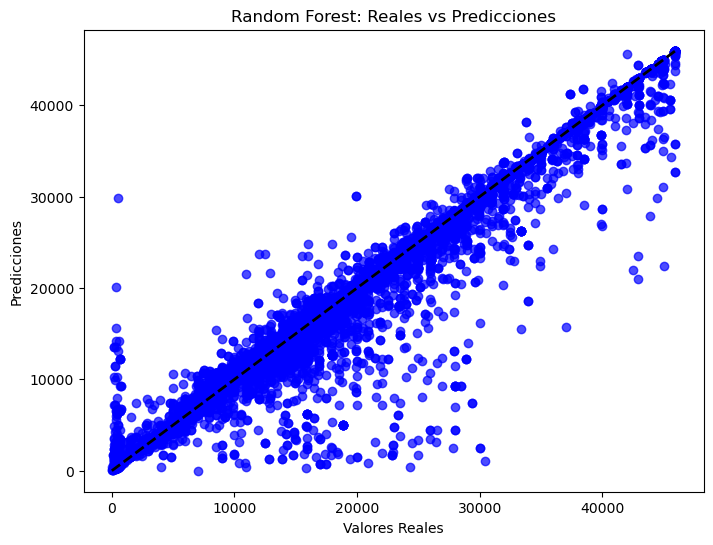

In [ ]:
# 📈 Gráfico de predicciones
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_rf, alpha=0.7, color='blue')
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Random Forest: Reales vs Predicciones')
plt.show()